In [1]:
%%time
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from dataclasses import dataclass
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd


@dataclass
class Config:
    project_dir: Path = Path("../../")
    model_dir: Path = project_dir / "models"
    outputs_dir: Path = project_dir / "outputs"
    data_dir: Path = project_dir / "data"
    raw_dir: Path = data_dir / "raw"
    interim_dir: Path = data_dir / "interim"
    processed_dir: Path = data_dir / "processed"
    results_dir: Path = project_dir / "results"
    results_agg_dir: Path = results_dir / "agg"
    results_figs_dir: Path = results_dir / "figs"


config = Config()
sys.path.append(str(config.project_dir.resolve()))

CPU times: user 275 ms, sys: 82.2 ms, total: 357 ms
Wall time: 667 ms


In [2]:
df_orders = pd.read_csv(config.interim_dir / "olist_orders_customer_merged.csv")
df_orders["order_purchase_timestamp"] = pd.to_datetime(
    df_orders["order_purchase_timestamp"]
)

df_item_products = pd.read_csv(
    config.interim_dir / "olist_item_product_seller_merged.csv"
)
df_sales = pd.merge(
    df_orders[["order_id", "order_purchase_timestamp"]],
    df_item_products[["order_id", "price"]],
    on="order_id",
    how="left",
)

## オーダーあたりの

In [3]:
df_sales

,order_id,order_purchase_timestamp,price
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,19.90
...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,174.90
113421,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,205.99
113422,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,179.99
113423,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,179.99


## 月毎の集計

In [4]:
from src.visualizer.vis_functions import plot_monthly_trend

### オーダー数

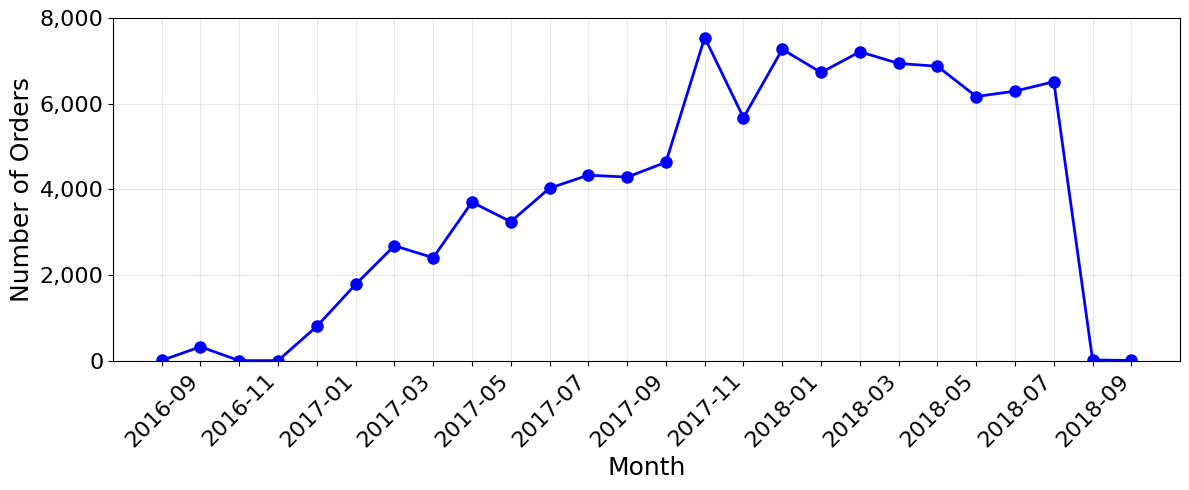

In [5]:
plot_monthly_trend(
    df=df_orders,
    agg_type="n_sales",
    output_path=config.results_figs_dir / "monthly_orders.png",
)

### 売り上げ

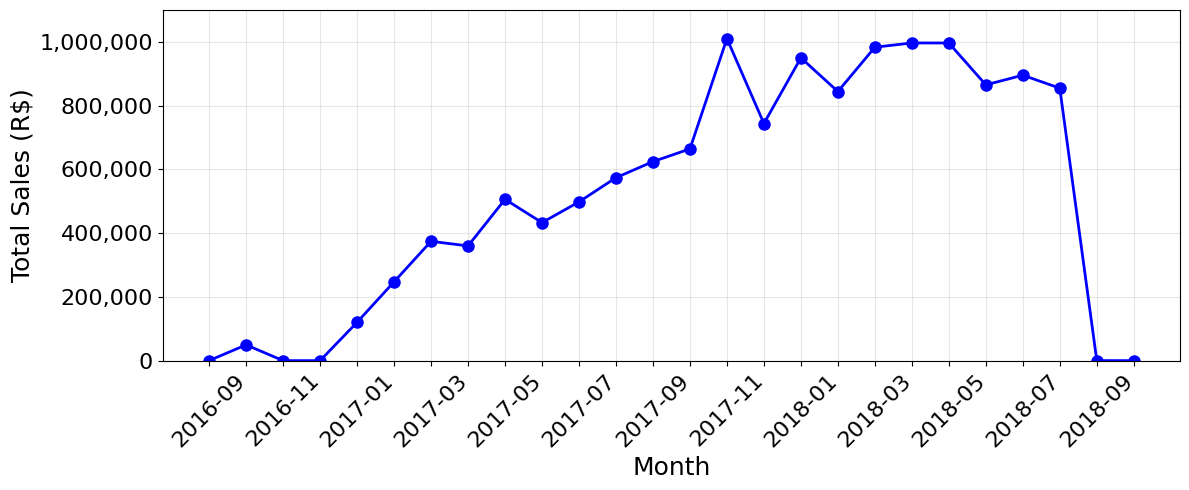

In [6]:
plot_monthly_trend(
    df=df_sales,
    agg_type="sales",
    output_path=config.results_figs_dir / "monthly_sales.png",
)

### 利用者数

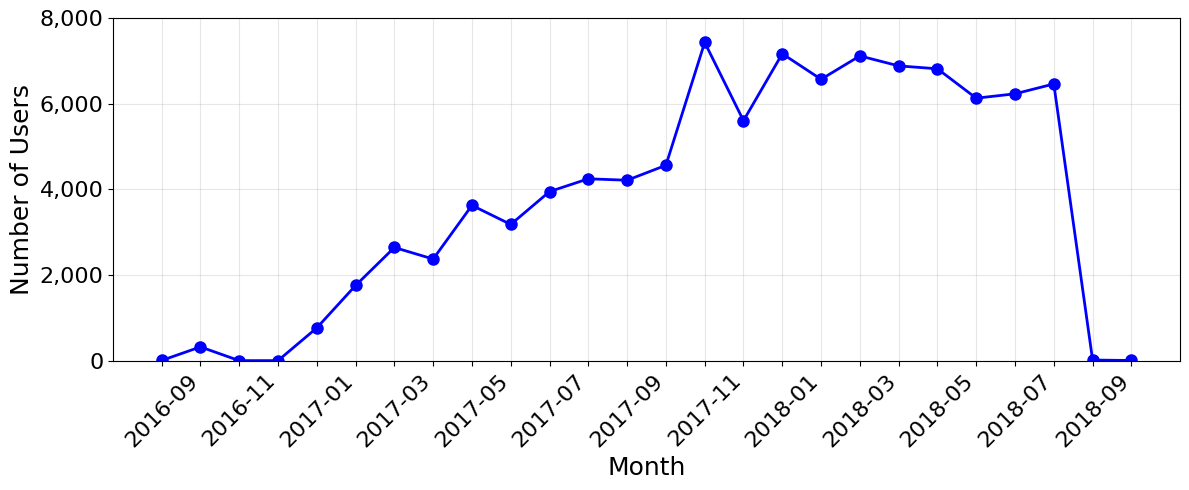

In [7]:
plot_monthly_trend(
    df=df_orders,
    agg_type="user",
    output_path=config.results_figs_dir / "monthly_users.png",
)

### 販売者数

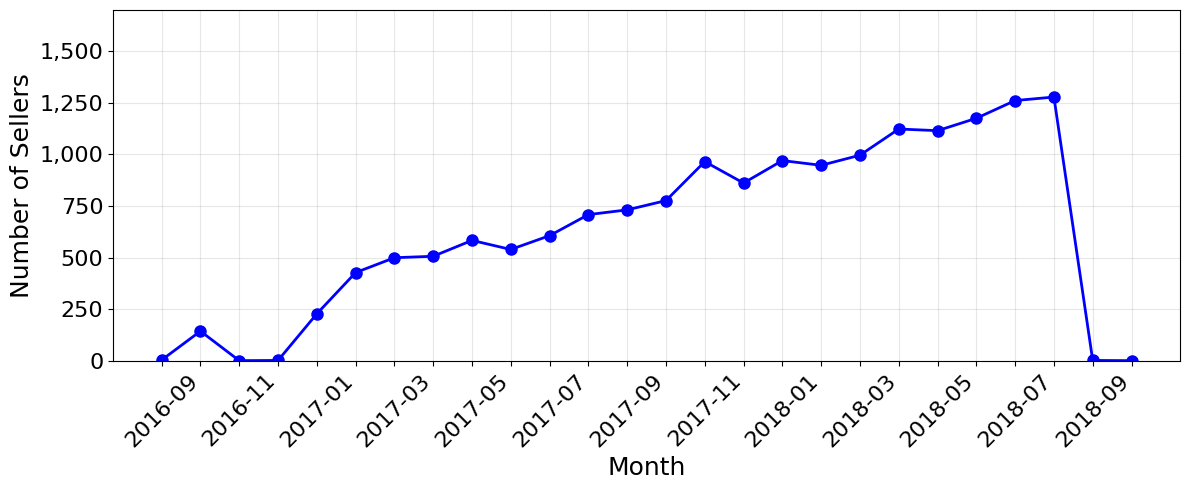

In [8]:
df_order_seller_merged = pd.merge(
    df_orders,
    df_item_products[["order_id", "seller_id"]].drop_duplicates(),
    on="order_id",
    how="left",
)
plot_monthly_trend(
    df=df_order_seller_merged,
    agg_type="seller",
    output_path=config.results_figs_dir / "monthly_sellers.png",
)

## 日毎の集計

In [10]:
daily_orders

,order_purchase_timestamp,count
0,2016-09-04,1
1,2016-09-05,1
2,2016-09-13,1
3,2016-09-15,1
4,2016-10-02,1
...,...,...
629,2018-09-29,1
630,2018-10-01,1
631,2018-10-03,1
632,2018-10-16,1


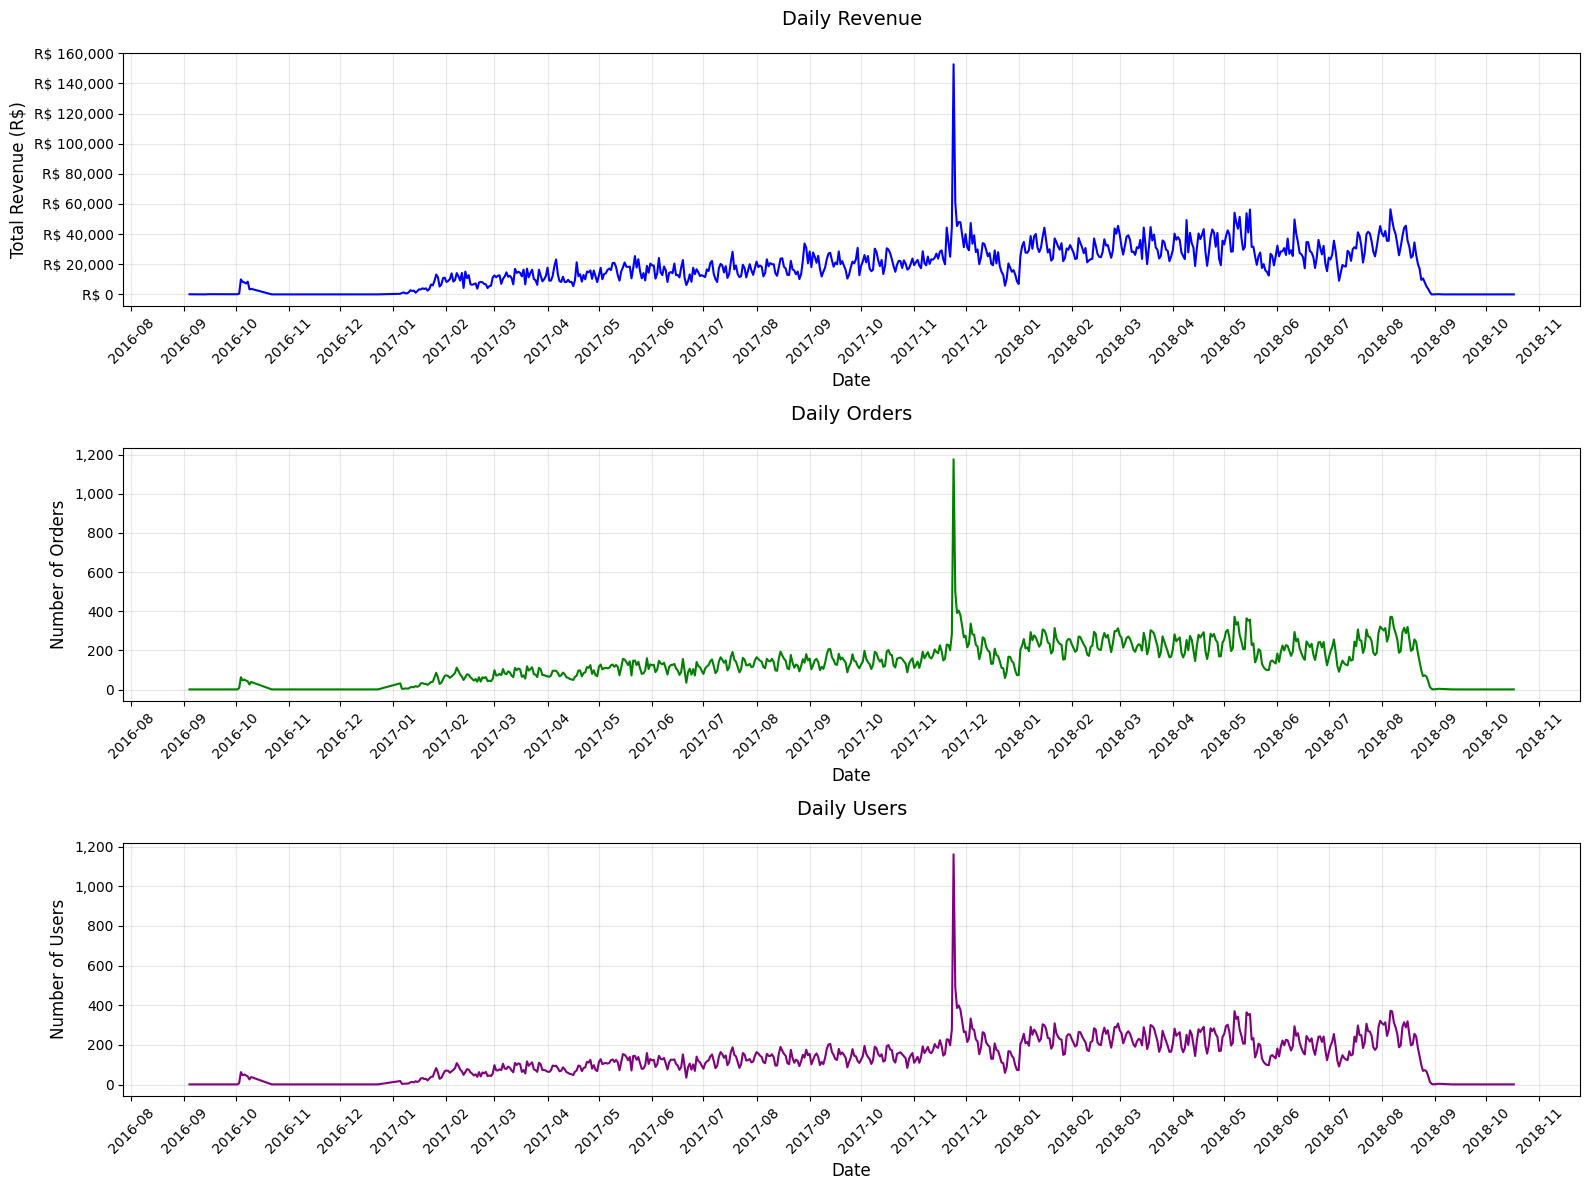

In [9]:
# 日次で集計
daily_orders = (
    df_orders.groupby(df_orders["order_purchase_timestamp"].dt.date)["order_id"]
    .count()
    .reset_index(name="count")
)

# 日次の売上集計
daily_revenue = (
    df_sales.groupby(df_sales["order_purchase_timestamp"].dt.date)["price"]
    .sum()
    .reset_index(name="total_revenue")
)

# 日次のユニークユーザー数集計
daily_users = (
    df_orders.groupby(df_orders["order_purchase_timestamp"].dt.date)
    .agg({"customer_unique_id": "nunique"})
    .reset_index()
)

# グラフ描画
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# 1. Daily Revenue (売上)
axes[0].plot(
    daily_revenue["order_purchase_timestamp"],
    daily_revenue["total_revenue"],
    marker="",
    linewidth=1.5,
    color="blue",
)
axes[0].grid(True, alpha=0.3)
axes[0].set_title("Daily Revenue", pad=20, fontsize=14)
axes[0].set_xlabel("Date", fontsize=12)
axes[0].set_ylabel("Total Revenue (R$)", fontsize=12)

locator = mdates.MonthLocator(interval=1)
formatter = mdates.DateFormatter("%Y-%m")
axes[0].xaxis.set_major_locator(locator)
axes[0].xaxis.set_major_formatter(formatter)
axes[0].tick_params(axis="x", rotation=45)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"R$ {x:,.0f}"))

# 2. Daily Sales (注文数)
axes[1].plot(
    daily_orders["order_purchase_timestamp"],
    daily_orders["count"],
    marker="",
    linewidth=1.5,
    color="green",
)
axes[1].grid(True, alpha=0.3)
axes[1].set_title("Daily Orders", pad=20, fontsize=14)
axes[1].set_xlabel("Date", fontsize=12)
axes[1].set_ylabel("Number of Orders", fontsize=12)
axes[1].xaxis.set_major_locator(locator)
axes[1].xaxis.set_major_formatter(formatter)
axes[1].tick_params(axis="x", rotation=45)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x):,}"))

# 3. Daily Users (ユニークユーザー数)
axes[2].plot(
    daily_users["order_purchase_timestamp"],
    daily_users["customer_unique_id"],
    marker="",
    linewidth=1.5,
    color="purple",
)
axes[2].grid(True, alpha=0.3)
axes[2].set_title("Daily Users", pad=20, fontsize=14)
axes[2].set_xlabel("Date", fontsize=12)
axes[2].set_ylabel("Number of Users", fontsize=12)
axes[2].xaxis.set_major_locator(locator)
axes[2].xaxis.set_major_formatter(formatter)
axes[2].tick_params(axis="x", rotation=45)
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x):,}"))

plt.tight_layout()
plt.savefig(config.results_figs_dir / "daily_data.png")
plt.show()